In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# 1. EDA
- Visualize sample
- Number of datasets
- Image stats (Size distributions)
- Image simiarity

## 1. Visualize samples

In [4]:
num_of_images = 5
def show_n_images(num_of_images, path, folder, label):
    """
    return: Show n images from the path/folder/label
    """

    images = os.listdir(os.path.join(path, folder, label))
    plt.figure(figsize=(15, 5))

    for i in range(num_of_images):
        plt.subplot(2, 5, i+1)
        img = cv2.imread(os.path.join(path, folder, label, images[i]))
        plt.imshow(img)
        plt.title(str(i+1))
        plt.axis('off')    
    plt.suptitle(label)      
    plt.show()

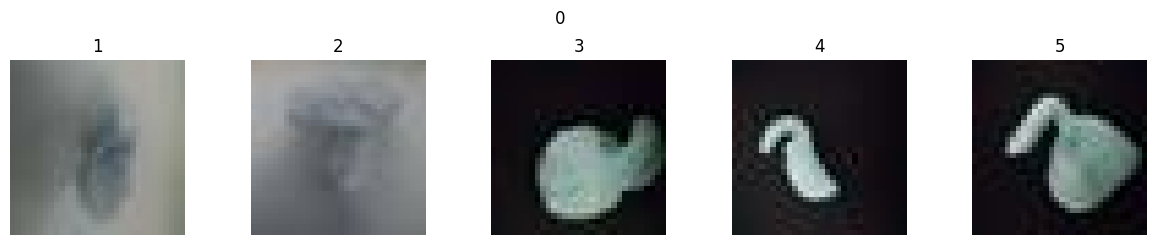

In [5]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[0])

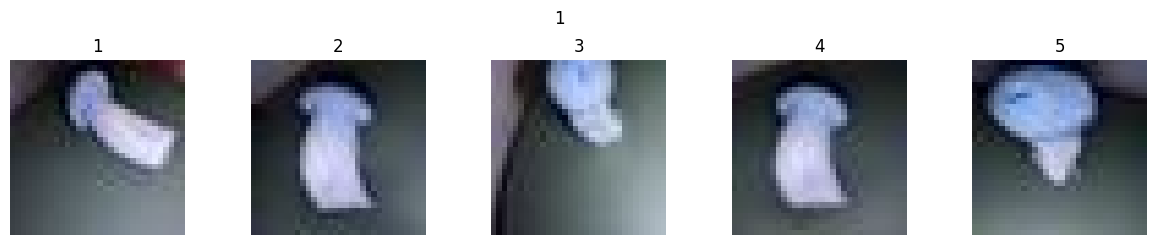

In [6]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[1])

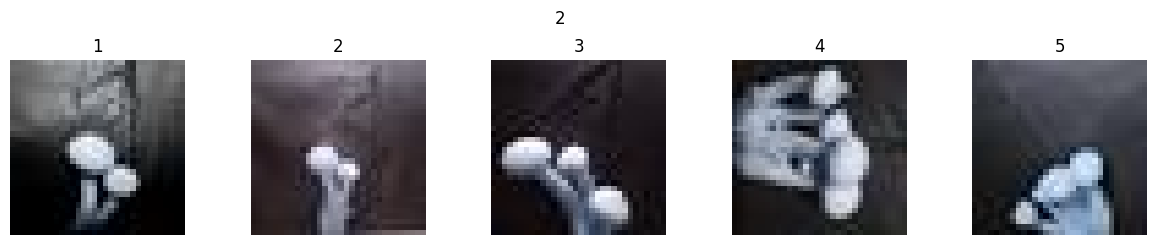

In [7]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[2])

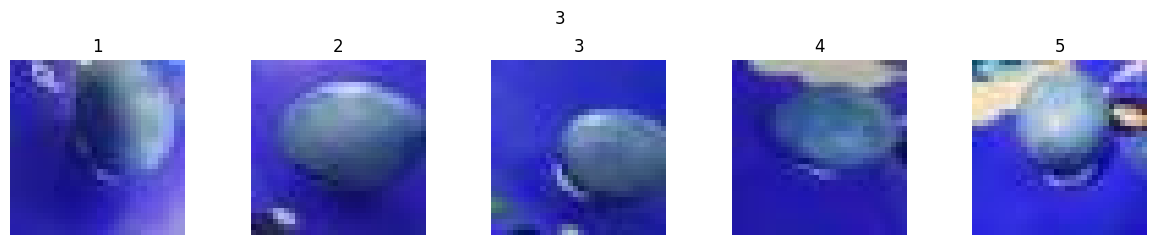

In [8]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[3])

## 2. number of datasets

In [9]:
def data_info(path, folders, labels):
    """
    return: dataframe contains number of images in each folder
    """
    stats = {
        "train": [],
        "val": [],
        "test": []
    }

    for f in folders:
        for l in labels:
            images = os.listdir(os.path.join(path, f, l))
            stats[f].append(len(images))    

    df = pd.DataFrame(stats, index=labels)
    return df

   train  val  test
0    180   30    90
1    180   30    90
2    180   30    90
3    180   30    90


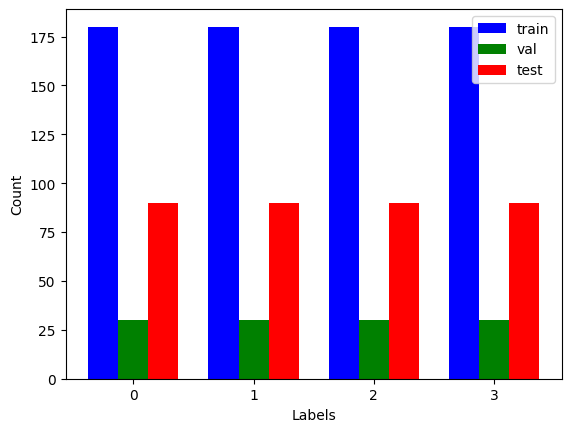

In [14]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

df = data_info(path, folders, labels)
print(df)

x = np.arange(len(df.index))
width = 0.25

length = len(labels)
# setup width of bar, then offset using "width"
plt.bar(np.array(range(0, length)) - width, df["train"], width=width, color='b', label='train')
plt.bar(x, df["val"], width=width, color='g', label='val')
plt.bar(x + width, df["test"], width=width, color='r', label='test')

plt.xticks(x, df.index)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend()
plt.show()

## 3. Image stats (size distributions)

In [15]:
from collections import Counter

def plot_distribution(path, folders, labels):
    """
    return: plot distribution of width, height, and ratio of images
    """
    width_dis = [] # save width size
    height_dis = [] # save height size
    ratio_dis = [] # save ratio

    for f in folders:
        for l in labels:
            images = os.listdir(os.path.join(path, f, l))
            for i in images:
                img = cv2.imread(os.path.join(path, f, l, i))

                # save stats
                width_dis.append(img.shape[1])
                height_dis.append(img.shape[0])
                ratio_dis.append(img.shape[1]/img.shape[0])

    # plot subplots, each subplot is a histogram
    fig, axes = plt.subplots(1, 3, figsize=(10, 6))
    most_common_width = Counter(width_dis).most_common(1)[0][0]
    most_common_height = Counter(height_dis).most_common(1)[0][0]
    most_common_ratio = Counter(ratio_dis).most_common(1)[0][0]
    print(most_common_width, most_common_height, most_common_ratio)

    axes[0].hist(width_dis, bins=100)
    axes[0].set_xlabel("Width size")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Width size distribution")

    axes[1].hist(height_dis, bins=100)
    axes[1].set_xlabel("Height size")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Height size distribution")

    axes[2].hist(ratio_dis, bins=100)
    axes[2].set_xlabel("Ratio")
    axes[2].set_ylabel("Frequency")
    axes[2].set_title("Ratio distribution")
    plt.show()

32 32 1.0


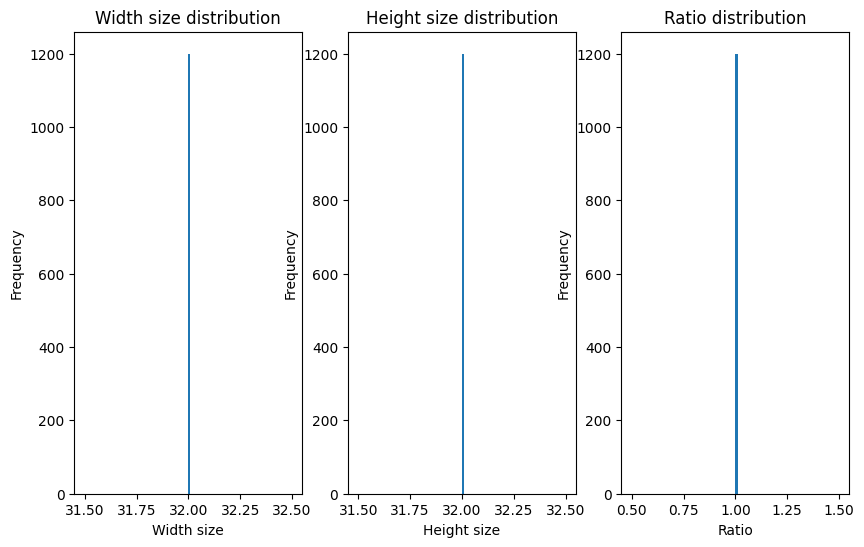

In [16]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

plot_distribution(path, folders, labels)

## 4. Check duplicate images (use imagehash)

In [10]:
!pip install imagehash

In [11]:
import os
import cv2
from tqdm import tqdm
from PIL import Image
import imagehash
from multiprocessing import Pool

def compute_hash(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return image_path, None
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).resize((256, 256))
    return image_path, imagehash.phash(pil_img)

def find_duplicates(image_paths, threshold=5):
    with Pool() as pool:
        results = pool.map(compute_hash, image_paths)
    
    # Build a hashmap
    hash_dict = {path: h for path, h in results if h is not None}
    duplicates = {}
    
    paths = list(hash_dict.keys())
    n = len(paths)
    for i in tqdm(range(n)):
        for j in range(i + 1, n):
            if abs(hash_dict[paths[i]] - hash_dict[paths[j]]) <= threshold:
                duplicates[paths[i]] = paths[j]
    return duplicates

if __name__ == "__main__":
    path = "../data"
    folders = ["train", "val", "test"]
    labels = ["NORMAL", "PNEUMONIA"]
    
    image_paths = []
    for f in folders:
        for l in labels:
            folder = os.path.join(path, f, l)
            if os.path.isdir(folder):
                image_paths.extend([os.path.join(folder, i) for i in os.listdir(folder)])
    
    duplicates = find_duplicates(image_paths, threshold=5)
    print(f"Found {len(duplicates)} duplicate images.")
    for dup in duplicates:
        print(dup)
    # Optionally, remove duplicate files
    # for dup in duplicates:
    #     os.remove(dup)
    #     print(f"Removed: {dup}")

100%|██████████| 1537/1537 [00:03<00:00, 434.01it/s]

Found 121 duplicate images.
../data/train/NORMAL/IM-0127-0001.jpeg
../data/train/NORMAL/IM-0158-0001.jpeg
../data/train/NORMAL/IM-0189-0001.jpeg
../data/train/NORMAL/IM-0191-0001.jpeg
../data/train/NORMAL/IM-0223-0001.jpeg
../data/train/NORMAL/IM-0225-0001.jpeg
../data/train/NORMAL/IM-0237-0001.jpeg
../data/train/NORMAL/IM-0266-0001.jpeg
../data/train/NORMAL/IM-0269-0001.jpeg
../data/train/NORMAL/IM-0273-0001.jpeg
../data/train/NORMAL/IM-0282-0001.jpeg
../data/train/NORMAL/IM-0290-0001.jpeg
../data/train/NORMAL/IM-0292-0001.jpeg
../data/train/NORMAL/IM-0299-0001.jpeg
../data/train/NORMAL/IM-0329-0001.jpeg
../data/train/NORMAL/IM-0354-0001.jpeg
../data/train/NORMAL/IM-0383-0001.jpeg
../data/train/NORMAL/IM-0384-0001.jpeg
../data/train/NORMAL/IM-0408-0001.jpeg
../data/train/NORMAL/IM-0495-0001.jpeg
../data/train/NORMAL/IM-0502-0001.jpeg
../data/train/NORMAL/IM-0505-0001.jpeg
../data/train/NORMAL/IM-0507-0001.jpeg
../data/train/NORMAL/IM-0519-0001-0001.jpeg
../data/train/NORMAL/IM-0523-00

In [12]:
print(duplicates)

{'../data/train/NORMAL/IM-0127-0001.jpeg': '../data/val/NORMAL/IM-0127-0001.jpeg', '../data/train/NORMAL/IM-0158-0001.jpeg': '../data/val/NORMAL/IM-0158-0001.jpeg', '../data/train/NORMAL/IM-0189-0001.jpeg': '../data/test/NORMAL/IM-0305-0001.jpeg', '../data/train/NORMAL/IM-0191-0001.jpeg': '../data/test/NORMAL/IM-0191-0001.jpeg', '../data/train/NORMAL/IM-0223-0001.jpeg': '../data/train/NORMAL/IM-0551-0001-0001.jpeg', '../data/train/NORMAL/IM-0225-0001.jpeg': '../data/train/NORMAL/IM-0504-0001.jpeg', '../data/train/NORMAL/IM-0237-0001.jpeg': '../data/test/NORMAL/NORMAL2-IM-1350-0001.jpeg', '../data/train/NORMAL/IM-0266-0001.jpeg': '../data/test/NORMAL/NORMAL2-IM-0892-0001.jpeg', '../data/train/NORMAL/IM-0269-0001.jpeg': '../data/val/NORMAL/IM-0269-0001.jpeg', '../data/train/NORMAL/IM-0273-0001.jpeg': '../data/val/NORMAL/IM-0273-0001.jpeg', '../data/train/NORMAL/IM-0282-0001.jpeg': '../data/val/NORMAL/IM-0282-0001.jpeg', '../data/train/NORMAL/IM-0290-0001.jpeg': '../data/train/NORMAL/IM-0

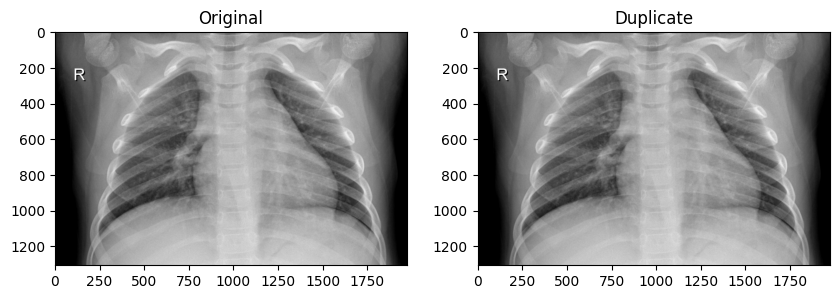

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.imread(list(duplicates.keys())[0]))
axes[0].set_title("Original")
axes[1].imshow(cv2.imread(list(duplicates.values())[0]))
axes[1].set_title("Duplicate")
plt.show()

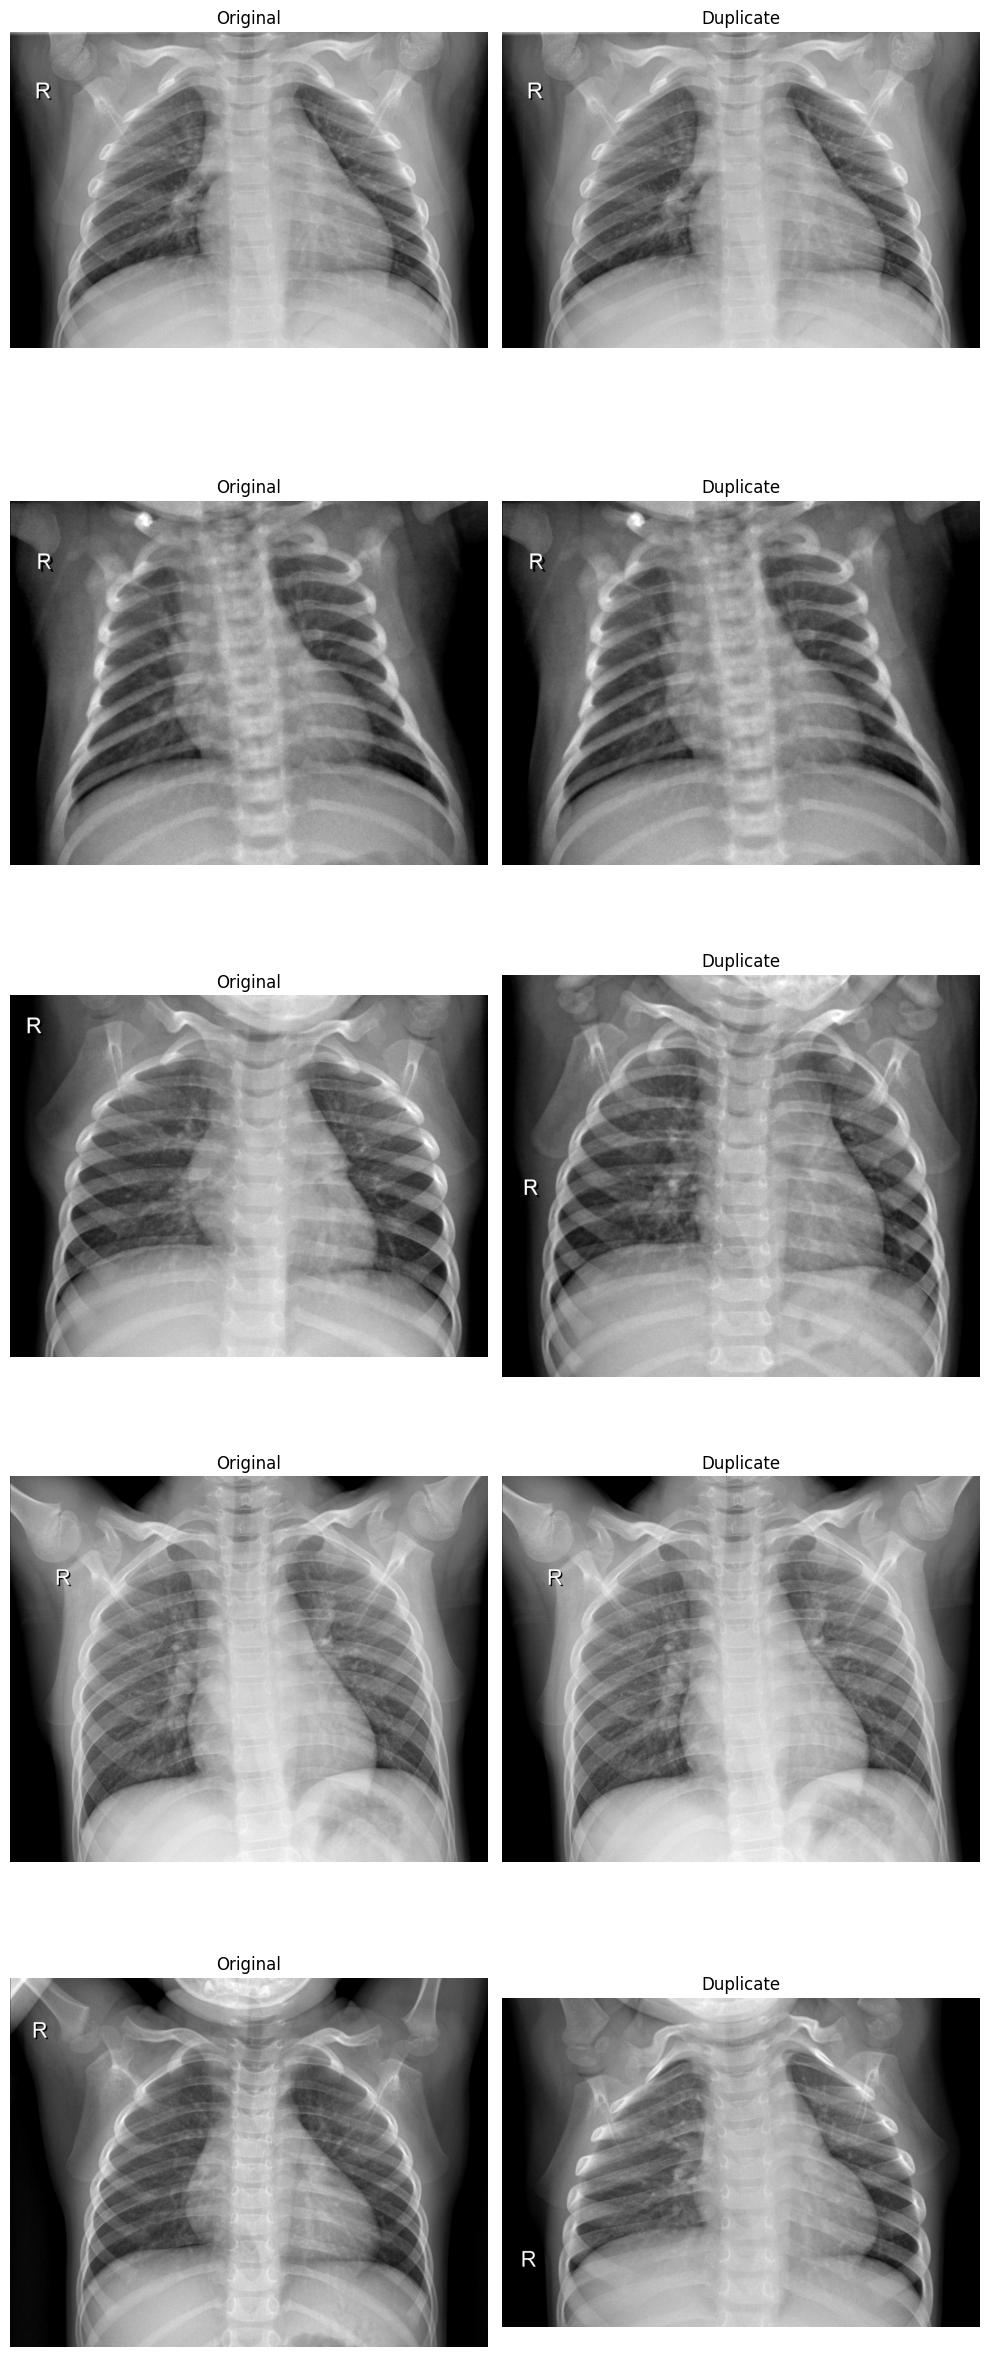

In [14]:
n = min(5, len(duplicates))

fig, axes = plt.subplots(n, 2, figsize=(10, n * 5))

for i in range(n):
    original_path = list(duplicates.keys())[i]
    duplicate_path = list(duplicates.values())[i]
    
    # Read images with cv2 (convert from BGR to RGB for correct color display)
    original_img = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
    duplicate_img = cv2.cvtColor(cv2.imread(duplicate_path), cv2.COLOR_BGR2RGB)
    
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(duplicate_img)
    axes[i, 1].set_title("Duplicate")
    
    # Optionally remove axis ticks
    axes[i, 0].axis("off")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Data cleaning

remove duplicate images

In [17]:
for d in list(duplicates.values()):
    try:
        os.remove(d)
    except FileNotFoundError:
        continue
    print(f"Removed: {d}")

Removed: ../data/val/NORMAL/IM-0562-0001.jpeg
Removed: ../data/val/NORMAL/IM-0575-0001.jpeg
Removed: ../data/val/NORMAL/IM-0612-0001-0002.jpeg
Removed: ../data/val/NORMAL/IM-0629-0001-0002.jpeg
Removed: ../data/train/NORMAL/NORMAL2-IM-1261-0001.jpeg
Removed: ../data/val/NORMAL/IM-0636-0001.jpeg
Removed: ../data/val/NORMAL/IM-0660-0001-0001.jpeg
Removed: ../data/val/NORMAL/IM-0664-0001.jpeg
Removed: ../data/val/NORMAL/IM-0666-0001-0001.jpeg
Removed: ../data/val/NORMAL/IM-0700-0001.jpeg
Removed: ../data/val/NORMAL/IM-0737-0001.jpeg
Removed: ../data/val/NORMAL/IM-0748-0001.jpeg
Removed: ../data/test/PNEUMONIA/person1230_virus_2081.jpeg
Removed: ../data/val/NORMAL/NORMAL2-IM-1096-0001.jpeg
Removed: ../data/train/NORMAL/NORMAL2-IM-1088-0001.jpeg
Removed: ../data/val/NORMAL/NORMAL2-IM-0472-0001.jpeg
Removed: ../data/val/NORMAL/NORMAL2-IM-0482-0001.jpeg
Removed: ../data/val/NORMAL/NORMAL2-IM-0497-0001.jpeg
Removed: ../data/val/NORMAL/NORMAL2-IM-0513-0001.jpeg
Removed: ../data/val/NORMAL/NORMA

- final stats

In [18]:
df = data_info(path, folders, labels)
print(df)

           train  val  test
NORMAL       433  171    60
PNEUMONIA    468  223    69
